
https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

https://www.kaggle.com/artgor/nn-baseline

https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480

https://www.kaggle.com/dimitreoliveira/deep-learning-keras-ga-revenue-prediction


# parse CSV

In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [2]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [5]:
%%time
df_train = load_df(path + 'train_orig.csv')
df_test = load_df(path + 'test_orig.csv')

df_train.to_csv(path + 'train_parsed.csv')
df_test.to_csv(path + 'test_parsed.csv')

CPU times: user 1min 47s, sys: 3.06 s, total: 1min 50s
Wall time: 1min 50s


# drop columns

In [13]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['train_orig.csv', 'test_parsed.csv', 'train_parsed.csv', 'test_orig.csv']


In [14]:
%%time
df_train = pd.read_csv(path +'train_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

<string>:2: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 21.6 s, sys: 929 ms, total: 22.6 s
Wall time: 22.2 s


## Align total # of colums

In [15]:
%%time
df_train, df_test = df_train.align(df_test, join='outer', axis=1)

df_train.replace(to_replace=np.nan, value=0, inplace=True)
df_test.replace(to_replace=np.nan, value=0, inplace=True)

CPU times: user 6.34 s, sys: 643 ms, total: 6.98 s
Wall time: 6.37 s


In [16]:
print(df_train.shape, df_test.shape, )

(903653, 55) (804684, 55)


## determine columns to drop

In [17]:
%%time

cols_not_unique = [col for col in df_train.columns if df_train[col].nunique() < 2]

cols_null_ratio_high = [col for col in df_train.columns if sum(df_train[col].isnull()) / len(df_train) >= 0.6]

cols_not_much_var = []
df_num = df_train.select_dtypes(include=[np.number])
df_var = df_num.var()
for x in df_num:
    if df_var[x] <= 30:
        cols_not_much_var.append(x)



CPU times: user 4.88 s, sys: 32.3 ms, total: 4.91 s
Wall time: 4.6 s


In [18]:
no_touch = ['fullVisitorId','transactionRevenue']

del_cols = []
del_cols.extend(cols_not_unique)
del_cols.extend(cols_null_ratio_high)
del_cols.extend(cols_not_much_var)
del_cols = list(set(del_cols))

del_cols = [x for x in del_cols if x not in no_touch]

del_cols

['screenColors',
 'longitude',
 'mobileInputSelector',
 'browserVersion',
 'bounces',
 'adwordsClickInfo.isVideoAd',
 'networkLocation',
 'cityId',
 'screenResolution',
 'adwordsClickInfo.page',
 'browserSize',
 'language',
 'mobileDeviceInfo',
 'flashVersion',
 'socialEngagementType',
 'operatingSystemVersion',
 'latitude',
 'newVisits',
 'mobileDeviceMarketingName',
 'adwordsClickInfo.criteriaParameters',
 'visits',
 'mobileDeviceBranding',
 'mobileDeviceModel']

In [19]:
df_train.drop(del_cols, axis=1, inplace=True)
df_test.drop(del_cols, axis=1, inplace=True)

In [20]:
print(df_train.shape, df_test.shape, )

(903653, 32) (804684, 32)


In [21]:
%%time
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

df_train.to_csv(path + 'train_dropped.csv')
df_test.to_csv(path + 'test_dropped.csv')

CPU times: user 27.5 s, sys: 957 ms, total: 28.4 s
Wall time: 27.7 s


# process columns

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_dropped.csv', 'train_dropped.csv', 'train_orig.csv', 'test_parsed.csv', 'train_parsed.csv', 'test_orig.csv']


In [2]:
%%time
df_train = pd.read_csv(path +'train_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

<string>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 9.85 s, sys: 562 ms, total: 10.4 s
Wall time: 10.1 s


## only for train dataset

In [3]:
# to float and log
df_train['transactionRevenue'] = df_train['transactionRevenue'].astype(float)
df_train['transactionRevenue'] = np.log1p(df_train['transactionRevenue'].fillna(0))


## to both train and test datasets

In [4]:
print(df_train.shape,df_test.shape)
print(df_train.columns)

(903653, 32) (804684, 32)
Index(['adContent', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId',
       'adwordsClickInfo.slot', 'browser', 'campaign', 'campaignCode',
       'channelGrouping', 'city', 'continent', 'country', 'date',
       'deviceCategory', 'fullVisitorId', 'hits', 'isMobile', 'isTrueDirect',
       'keyword', 'medium', 'metro', 'networkDomain', 'operatingSystem',
       'pageviews', 'referralPath', 'region', 'sessionId', 'source',
       'subContinent', 'transactionRevenue', 'visitId', 'visitNumber',
       'visitStartTime'],
      dtype='object')


### manually delete columns

In [5]:
del_cols = [
            'adContent', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId',
            'adwordsClickInfo.slot', 'campaignCode','city', 'country',
            'keyword', 'medium', 'metro', 'networkDomain', 
            'referralPath', 'region', 'sessionId', 'source',
            'subContinent', 'visitId', 'visitNumber','visitStartTime'
            ]


In [6]:
%%time

for x in del_cols:
    df_train.drop(x, axis=1, inplace=True)
    df_test.drop(x, axis=1, inplace=True)



CPU times: user 3.19 s, sys: 929 ms, total: 4.12 s
Wall time: 4.14 s


In [7]:
print(df_train.shape,df_test.shape)

(903653, 13) (804684, 13)


### analyze date

In [8]:
%%time
def dateCol(df):

    df['date'] = pd.to_datetime(df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df['weekend'] = df['weekday'].apply(lambda x: 1 if x>=5 else 0)
    
    return df

df_train = dateCol(df_train)
df_test = dateCol(df_test)

CPU times: user 3.37 s, sys: 29.1 ms, total: 3.4 s
Wall time: 2.68 s


### access count column

In [9]:
%%time
def userCount(df):
    df['cnt_per_day'] = df[['fullVisitorId','date']].groupby(['fullVisitorId','date'])['date'].transform('count')
    return df

df_train = userCount(df_train)
df_test = userCount(df_test)

CPU times: user 3.55 s, sys: 48.3 ms, total: 3.6 s
Wall time: 3.01 s


### category string to numbers

In [11]:
no_touch = ['fullVisitorId','transactionRevenue']
cat_cols = [x for x in df_train.columns if df_train[x].dtypes == 'object' or df_train[x].dtypes == 'bool']
cat_cols = [x for x in cat_cols if df_train[x].nunique() <= 100]
cat_cols = [x for x in cat_cols if x not in no_touch]

cat_cols

['browser',
 'campaign',
 'channelGrouping',
 'continent',
 'deviceCategory',
 'isMobile',
 'isTrueDirect',
 'operatingSystem']

In [12]:
%%time

for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))


CPU times: user 33.9 s, sys: 3.25 s, total: 37.1 s
Wall time: 29.4 s


In [13]:
%%time
l = {}
for x in df_train.columns:
    l[x] = x.replace(' ','').replace('(','').replace(')','').replace('-','')[:20]

df_train = df_train.rename(columns=l)
df_test = df_test.rename(columns=l)



CPU times: user 271 ms, sys: 272 ms, total: 543 ms
Wall time: 278 ms


In [14]:
no_touch = ['fullVisitorId','transactionRevenue','date']
l_float = [x for x in df_train.columns if x not in no_touch]
l_float

['browser',
 'campaign',
 'channelGrouping',
 'continent',
 'deviceCategory',
 'hits',
 'isMobile',
 'isTrueDirect',
 'operatingSystem',
 'pageviews',
 'month',
 'weekday',
 'weekend',
 'cnt_per_day']

In [15]:
%%time

df_train[l_float] = df_train[l_float].values.astype('float')
df_test[l_float] = df_test[l_float].values.astype('float')

CPU times: user 4.7 s, sys: 800 ms, total: 5.5 s
Wall time: 2.91 s


In [16]:
df_train.shape, df_test.shape

((903653, 17), (804684, 17))

### save adjusted DFs

In [17]:
%%time
df_train.to_csv(path + 'train_adj.csv')
df_test.to_csv(path + 'test_adj.csv')

CPU times: user 21.2 s, sys: 190 ms, total: 21.4 s
Wall time: 21.4 s


# create new dataset: aggregated by users

In [18]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'train_dropped.csv', 'train_orig.csv', 'test_parsed.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv']


In [19]:
%%time
df_train = pd.read_csv(path +'train_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

CPU times: user 3.09 s, sys: 172 ms, total: 3.26 s
Wall time: 2.97 s


In [20]:
df_train.shape, df_test.shape

((903653, 17), (804684, 17))

In [21]:
def statCols(df):
    df['access_Days'] = df.groupby(['fullVisitorId','date'])['date'].transform('count')
    
    df['avg_hitperDay'] = df.groupby(['fullVisitorId','date'])['hits'].transform('mean')
    df['ttl_hitbyUser'] = df.groupby(['fullVisitorId'])['hits'].transform('sum')

    df['avg_viewperDay'] = df.groupby(['fullVisitorId','date'])['pageviews'].transform('mean')
    df['ttl_viewbyUser'] = df.groupby(['fullVisitorId'])['pageviews'].transform('sum')

    return df

In [22]:
%%time
df_train = statCols(df_train)
df_test = statCols(df_test)

CPU times: user 16.9 s, sys: 372 ms, total: 17.3 s
Wall time: 14.4 s


In [24]:
df_train.describe()

,browser,campaign,channelGrouping,continent,deviceCategory,hits,isMobile,isTrueDirect,operatingSystem,pageviews,transactionRevenue,month,weekday,weekend,cnt_per_day,access_Days,avg_hitperDay,ttl_hitbyUser,avg_viewperDay,ttl_viewbyUser
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000
mean,44.014666,4.280819,4.632267,2.716869,0.298370,4.596538,0.264618,0.303219,12.949865,3.849338,0.227118,6.987671,2.735183,0.219117,1.193563,1.193563,4.596538,18.775357,3.849338,15.311467
std,15.389741,1.510145,1.774791,0.885558,0.526058,9.641437,0.441130,0.459649,8.159630,7.025002,2.003710,3.484576,1.929072,0.413649,0.611397,0.611397,9.027772,123.174505,6.587883,100.218298
min,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,35.000000,4.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,0.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,35.000000,4.000000,4.000000,2.000000,0.000000,2.000000,0.000000,0.000000,20.000000,1.000000,0.000000,7.000000,3.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000
75%,47.000000,4.000000,7.000000,3.000000,1.000000,4.000000,1.000000,1.000000,20.000000,4.000000,0.000000,10.000000,4.000000,0.000000,1.000000,1.000000,4.000000,9.000000,4.000000,8.000000
max,117.000000,34.000000,7.000000,5.000000,2.000000,500.000000,1.000000,1.000000,23.000000,469.000000,23.864375,12.000000,6.000000,1.000000,32.000000,32.000000,500.000000,4995.000000,466.000000,4160.000000


In [33]:
def aggregate_by_users(df):
    users = df.groupby(['fullVisitorId']).agg('mean')
    users['transactionRevenue'] = df.groupby(['fullVisitorId'])['transactionRevenue'].agg('sum')
    users['hits'] = df.groupby(['fullVisitorId'])['hits'].agg('sum')
    users['pageviews'] = df.groupby(['fullVisitorId'])['pageviews'].agg('sum')
    users['month_min'] = df.groupby(['fullVisitorId'])['month'].agg('min')
    users['month_max'] = df.groupby(['fullVisitorId'])['month'].agg('max')
    users['weekend_min'] = df.groupby(['fullVisitorId'])['weekend'].agg('min')
    users['weekend_max'] = df.groupby(['fullVisitorId'])['weekend'].agg('max')
    return users


In [34]:
%%time

df_test['transactionRevenue'] = 0

df_user_train = aggregate_by_users(df_train)
df_user_test = aggregate_by_users(df_test)


CPU times: user 24.7 s, sys: 509 ms, total: 25.2 s
Wall time: 21.6 s


In [35]:
print(df_train.shape,df_test.shape)
print(df_train.fullVisitorId.nunique(),df_test.fullVisitorId.nunique())
print(df_user_train.shape,df_user_test.shape)


(903653, 22) (804684, 22)
714167 617242
(714167, 24) (617242, 24)


In [36]:
df_user_train.describe()

,browser,campaign,channelGrouping,continent,deviceCategory,hits,isMobile,isTrueDirect,operatingSystem,pageviews,...,cnt_per_day,access_Days,avg_hitperDay,ttl_hitbyUser,avg_viewperDay,ttl_viewbyUser,month_min,month_max,weekend_min,weekend_max
count,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,...,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000
mean,44.913690,4.252122,4.727070,2.775635,0.300743,5.816112,0.266703,0.204475,13.271820,4.870662,...,1.066602,1.066602,3.917565,5.816112,3.340949,4.870662,6.983504,7.108938,0.215469,0.246599
std,15.858845,1.356555,1.791039,0.894151,0.527598,18.417008,0.442174,0.376182,8.165969,14.128870,...,0.289029,0.289029,7.276184,18.417008,5.350892,14.128870,3.487806,3.471920,0.411148,0.431032
min,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,35.000000,4.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,0.000000,0.000000
50%,35.000000,4.000000,4.000000,3.000000,0.000000,2.000000,0.000000,0.000000,20.000000,2.000000,...,1.000000,1.000000,1.500000,2.000000,1.333333,2.000000,7.000000,7.000000,0.000000,0.000000
75%,66.000000,4.000000,7.000000,4.000000,1.000000,4.000000,1.000000,0.000000,20.000000,4.000000,...,1.000000,1.000000,4.000000,4.000000,3.000000,4.000000,10.000000,10.000000,0.000000,0.000000
max,117.000000,34.000000,7.000000,5.000000,2.000000,4995.000000,1.000000,1.000000,23.000000,4160.000000,...,27.918919,27.918919,500.000000,4995.000000,466.000000,4160.000000,12.000000,12.000000,1.000000,1.000000


In [37]:
%%time
df_user_train = df_user_train.fillna(0)
df_user_test = df_user_test.fillna(0)

df_user_train.to_csv(path + 'user_train.csv')
df_user_test.to_csv(path + 'user_test.csv')

CPU times: user 18.4 s, sys: 233 ms, total: 18.6 s
Wall time: 18.2 s


# Normalize

In [38]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv']


In [39]:
%%time
df_user_train = pd.read_csv(path +'user_train.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_test = pd.read_csv(path +'user_test.csv', index_col = 0, dtype={'fullVisitorId': 'str'})


CPU times: user 3.9 s, sys: 212 ms, total: 4.11 s
Wall time: 3.84 s


In [41]:
print(df_user_train.shape,df_user_test.shape)
print(df_user_train.columns)

(714167, 24) (617242, 24)
Index(['browser', 'campaign', 'channelGrouping', 'continent', 'deviceCategory',
       'hits', 'isMobile', 'isTrueDirect', 'operatingSystem', 'pageviews',
       'transactionRevenue', 'month', 'weekday', 'weekend', 'cnt_per_day',
       'access_Days', 'avg_hitperDay', 'ttl_hitbyUser', 'avg_viewperDay',
       'ttl_viewbyUser', 'month_min', 'month_max', 'weekend_min',
       'weekend_max'],
      dtype='object')


In [42]:
%%time

tgt = [x for x in df_user_train.columns if x not in ['fullVisitorId','transactionRevenue'] ]

sc = MinMaxScaler()
df_user_train[tgt] = sc.fit_transform(df_user_train[tgt])
df_user_test[tgt] = sc.transform(df_user_test[tgt])

CPU times: user 2.91 s, sys: 408 ms, total: 3.31 s
Wall time: 1.71 s


In [43]:
df_user_train.describe()

,browser,campaign,channelGrouping,continent,deviceCategory,hits,isMobile,isTrueDirect,operatingSystem,pageviews,...,cnt_per_day,access_Days,avg_hitperDay,ttl_hitbyUser,avg_viewperDay,ttl_viewbyUser,month_min,month_max,weekend_min,weekend_max
count,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,...,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000
mean,0.383878,0.008404,0.675296,0.555127,0.150372,0.000964,0.266703,0.204475,0.577036,0.001171,...,0.002474,0.002474,0.005847,0.000964,0.007169,0.001171,0.543955,0.555358,0.215469,0.246599
std,0.135546,0.045218,0.255863,0.178830,0.263799,0.003688,0.442174,0.376182,0.355042,0.003396,...,0.010737,0.010737,0.014582,0.003688,0.011483,0.003396,0.317073,0.315629,0.411148,0.431032
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.299145,0.000000,0.571429,0.400000,0.000000,0.000000,0.000000,0.000000,0.304348,0.000240,...,0.000000,0.000000,0.000000,0.000000,0.002146,0.000240,0.272727,0.272727,0.000000,0.000000
50%,0.299145,0.000000,0.571429,0.600000,0.000000,0.000200,0.000000,0.000000,0.869565,0.000481,...,0.000000,0.000000,0.001002,0.000200,0.002861,0.000481,0.545455,0.545455,0.000000,0.000000
75%,0.564103,0.000000,1.000000,0.800000,0.500000,0.000601,1.000000,0.000000,0.869565,0.000962,...,0.000000,0.000000,0.006012,0.000601,0.006438,0.000962,0.818182,0.818182,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
%%time
df_user_train.to_csv(path + 'user_train_n.csv')
df_user_test.to_csv(path + 'user_test_n.csv')

CPU times: user 28.2 s, sys: 364 ms, total: 28.5 s
Wall time: 28.5 s


# visualize correlations

In [45]:
%%time
df_user_train = pd.read_csv(path +'user_train.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_train.drop('transactionRevenue', axis = 1, inplace=True)


CPU times: user 2.11 s, sys: 156 ms, total: 2.27 s
Wall time: 2.16 s


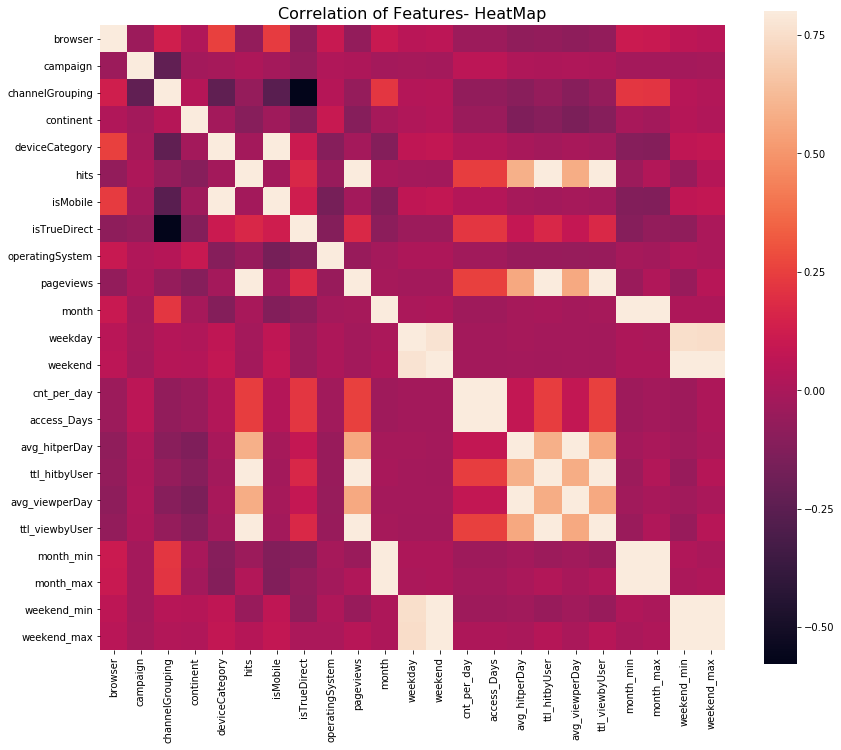

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Features- HeatMap',y=1,size=16)
sns.heatmap(df_user_train.corr(),square = True,  vmax=0.8)
